# Initial data exploration and structure

The purpose of this notebook is to explore and understand the structure and content of the Job Descriptions 2025 dataset.

**Main points**

* Assess the quality and completeness of the dataset.
* Examine the distribution of job categories (Tech vs. Non-Tech).
* Analyze the overall characteristics of the job descriptions, such as text length, vocabulary diversity, and common terms.
* Identify potential issues or insights that will guide the next steps in text preprocessing and NLP modeling.

# ⚙️ Configuration

In [ ]:
import kagglehub
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re
import ast
from sentence_transformers import SentenceTransformer
from sklearn.cluster import AgglomerativeClustering


# ♻️ Import data

The information is stored in a json file. We download the files and open the json one.

In [2]:
# Download data from Kaggle
path = kagglehub.dataset_download("adityarajsrv/job-descriptions-2025-tech-and-non-tech-roles")

# Save in this repository
df_raw = pd.read_json(os.path.join(path, "job_dataset.json"))

# 🔍 Data Exploration (EDA)

Now were are going to performe an EDA at table level. In the the fild `03_eda_language.ipynb` we will performe a more specific EDA, focus in the linguistic analyse.

## General information

We will take a look in the data structure: shape, nulls, duplacated

In [3]:
print(f"Rows: {df_raw.shape[0]:,} | Columns: {df_raw.shape[1]}")

Rows: 1,068 | Columns: 7


In [4]:
df_raw.sample(n=5, random_state=1)

,JobID,Title,ExperienceLevel,YearsOfExperience,Skills,Responsibilities,Keywords
457,13,Full Stack Developer - Experienced,Experienced,3–5 years,"[HTML5, CSS3, JavaScript, React, Angular, Vue....",[Develop and maintain full-stack applications ...,"[Full Stack Developer, Experienced, Mid-Level,..."
347,DS-F8,Fresher Data Scientist,Fresher,0-1,"[Python, R, SQL, Pandas, NumPy, Matplotlib, Se...","[Analyze small datasets to extract insights, B...","[Data Scientist, Python, R, SQL, Machine Learn..."
639,NE009,Network Intern,Fresher,0,"[DHCP, Subnetting, Cisco IOS, VPN Basics]","[Assist senior engineers on projects, Help con...","[Internship, Cisco IOS, Subnetting, DHCP]"
833,SRE-F-003,Site Reliability Engineer,Fresher,0-1,"[Python basics, Bash scripting basics, Linux a...","[Assist in setting up monitoring dashboards, S...","[Python, Bash, Linux, Docker, Kubernetes, AWS,..."
437,FE011,Frontend Developer - Experienced,Mid-Senior Level,3–6 years,"[HTML5, CSS3, JavaScript (ES6+), React/Redux, ...",[Design and develop advanced frontend applicat...,"[Frontend, Web Application Development, Mid-Se..."


In [5]:
df_raw.isnull().sum().sort_values(ascending=False)

Title                1
JobID                0
ExperienceLevel      0
YearsOfExperience    0
Skills               0
Responsibilities     0
Keywords             0
dtype: int64

In [6]:
# Duplicated only in the principal columns
duplicates = df_raw.duplicated(subset=(["Title", "JobID"])).sum()

print(f"Duplicated rows: {duplicates}")

Duplicated rows: 0


### 🧠 General infomation - Conclusions

* We are working with 1.068 registers with information in seven columns.
* Only one job has no information about Title. The other features are compleate.
* No duplicated rows (Title and JobId) were detected.

The structure of the data is solid to build any model.

## Catgorical distribution

We are going to explore the count in each level for the categorical variables: ExperienceLevel, YearsOfExperience, Skills, Keywords

### Experience level

There are some equivalent categories. The idea is group them into few labels. As there are few labels we will do it using a dictionarie.

In [7]:
print(f'Original labels: {df_raw["ExperienceLevel"].unique()}')

Original labels: ['Fresher' 'Experienced' 'Entry-Level' 'Mid-Senior Level' 'Senior-Level'
 'Mid-Level' 'Mid-Senior' 'Senior' 'Junior' 'Mid-level' 'Lead']


In [8]:
# Group different labels. 
mapping = {
    "Fresher": "Entry",
    "Entry-Level": "Entry",
    "Junior": "Entry",

    "Mid-Level": "Mid",
    "Mid-level": "Mid",

    "Mid-Senior Level": "Mid-Senior",
    "Mid-Senior": "Mid-Senior",

    "Experienced": "Senior",
    "Senior-Level": "Senior",
    "Senior": "Senior",
    "Lead": "Senior",   
}

# Create a new column
df_raw["ExperienceLevel_clean"] = (
    df_raw["ExperienceLevel"]
    .str.strip()
    .replace(mapping)
    .fillna("Other")
)

# Result
print(f'Final labels: {df_raw["ExperienceLevel_clean"].unique()}')

Final labels: ['Entry' 'Senior' 'Mid-Senior' 'Mid']


C:\Users\arual\AppData\Local\Temp\ipykernel_57108\1838106997.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(


Text(0, 0.5, 'Experience Level')

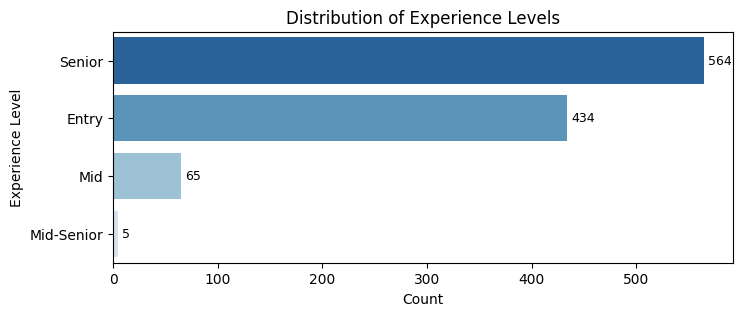

In [ ]:
# Plot

fig, ax = plt.subplots(figsize=(8, 3))

sns.countplot(
    y="ExperienceLevel_clean",
    data=df_raw,
    order=df_raw["ExperienceLevel_clean"].value_counts().index,
    ax=ax,
    palette="Blues_r"
)

# Add counts on bars
for container in ax.containers:
    ax.bar_label(container, fmt='%d', label_type='edge', padding=3, fontsize=9, color='black')

ax.set_title("Distribution of Experience Levels (clean)")
ax.set_xlabel("Count")
ax.set_ylabel("Experience Level")

### Years Of Experience

The codification of this column is very mixed. As it is related with the level, we are going to explore both variables together in order to make a cetegorization

In [11]:
exp_summary = (
    df_raw
    .groupby(["ExperienceLevel_clean", "YearsOfExperience"])
    .size()
    .reset_index(name="Count")
    .sort_values(by=["ExperienceLevel_clean", "YearsOfExperience"])
)

exp_summary

,ExperienceLevel_clean,YearsOfExperience,Count
0,Entry,0,48
1,Entry,0-1,247
2,Entry,0-1 Years,10
3,Entry,0-2,25
4,Entry,0–1 year,104
...,...,...,...
112,Senior,8–10 years,1
113,Senior,9,2
114,Senior,9+,8
115,Senior,9-12,3


In [19]:
# Clean the feature selecting only the number. If it's a range, we only mantain the first number of the interval.

def years_to_number(x):
    if pd.isna(x):
        return np.nan
    m = re.search(r'\d+(\.\d+)?', str(x))   # Found the first numerival partner
    return float(m.group(0)) if m else np.nan

# Apply and convet to int64
df_raw["YearsOfExperience_num"] = pd.to_numeric(df_raw["YearsOfExperience_num"], errors="coerce").astype("Int64")

# Check if nulls
print("Nulls:", df_raw["YearsOfExperience_num"].isna().sum())

# Comparation
df_raw[["YearsOfExperience", "YearsOfExperience_num"]]

Nulls: 0


,YearsOfExperience,YearsOfExperience_num
0,0-1,0
1,0-1,0
2,0-1,0
3,0-1,0
4,0-1,0
...,...,...
1063,5+,5
1064,4+,4
1065,5+,5
1066,4+,4


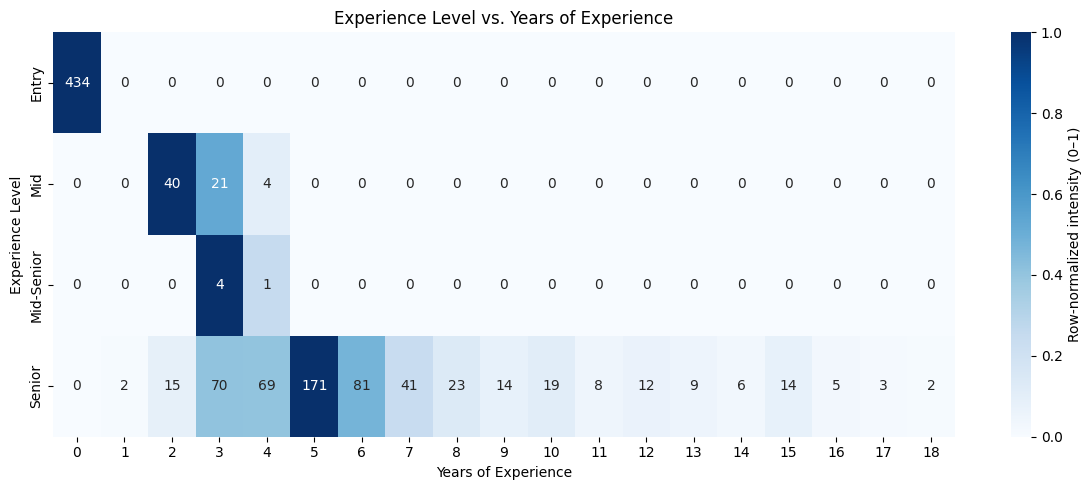

In [30]:
# Explore the relationship between ExperienceLevel_clean and YearsOfExperience

## a. Summary YearsOfExperience_num, ExperienceLevel_clean, Count
ys = year_summary.dropna(subset=["YearsOfExperience_num", "ExperienceLevel_clean"]).copy()
ys["YearsOfExperience_num"] = ys["YearsOfExperience_num"].astype(int)

# Pivot and sort by years
pivot_counts = (
    ys.pivot(index="ExperienceLevel_clean", columns="YearsOfExperience_num", values="Count")
      .fillna(0)
      .reindex(sorted(ys["YearsOfExperience_num"].unique()), axis=1)
)

# Normalization: for each row we scale by it maximun (it's only for present the color scale by row)
pivot_norm = pivot_counts.div(pivot_counts.max(axis=1).replace(0, np.nan), axis=0).fillna(0)

# Plot
plt.figure(figsize=(12, 5))

sns.heatmap(
    pivot_norm, cmap="Blues", vmin=0, vmax=1,
    annot=pivot_counts.astype(int), fmt="d",
    cbar_kws={"label": "Row-normalized intensity (0–1)"}
)
plt.title("Experience Level vs. Years of Experience")
plt.xlabel("Years of Experience")
plt.ylabel("Experience Level")
plt.tight_layout()
plt.show()


In [32]:
# Group Mid and Mid-Senior (rewritting ExperienceLevel_clean values)
df_raw["ExperienceLevel_clean"] = (
    df_raw["ExperienceLevel_clean"]
    .replace({"Mid-Senior": "Mid"})
)

# Print final labels
print(f'Final labels: {df_raw["ExperienceLevel_clean"].unique()}')

Final labels: ['Entry' 'Senior' 'Mid']


### Skills

Here we have of first challenge. Each job description use different way to name the same skill (ex. JavaScript, JavaScript [E6+], ...). For this reason, we need to standarize names. 

We are going to use semantic embeddings + unsupervised clustering --> The model undestands the meaning (not only the text similarity):

* Embedding: Vector of numbers that represents the meaning of one skill.

With this embeddings we can cluster them: similar skilss falls in the same cluster.

We use a pretrained model from Sentene Transformers that allows understand semantic similarity between short texts. Specifically, we use all-MiniLM-L6-v2 that has 22M parameters,

In [ ]:
# Prepare data. 

## Transform thee skill column into a list
df_raw["Skills_list"] = df_raw["Skills"].apply(
    lambda x: ast.literal_eval(x) if isinstance(x, str) else x
)

## Create a skill table as a copy of the original data but with as much rows as the skills and jobs 
df_skills = df_raw.explode("Skills_list").copy()                  
df_skills.rename(columns={"Skills_list": "Skill"}, inplace=True) 
df_skills["Skill"] = df_skills["Skill"].str.strip()

# Results
df_skills

,JobID,Title,ExperienceLevel,YearsOfExperience,Skills,Responsibilities,Keywords,ExperienceLevel_clean,YearsOfExperience_num,Skill
0,NET-F-001,.NET Developer,Fresher,0-1,"[C#, VB.NET basics, .NET Framework, .NET Core ...","[Assist in coding and debugging applications, ...","[.NET, C#, ASP.NET MVC, Entity Framework, SQL ...",Entry,0,C#
0,NET-F-001,.NET Developer,Fresher,0-1,"[C#, VB.NET basics, .NET Framework, .NET Core ...","[Assist in coding and debugging applications, ...","[.NET, C#, ASP.NET MVC, Entity Framework, SQL ...",Entry,0,VB.NET basics
0,NET-F-001,.NET Developer,Fresher,0-1,"[C#, VB.NET basics, .NET Framework, .NET Core ...","[Assist in coding and debugging applications, ...","[.NET, C#, ASP.NET MVC, Entity Framework, SQL ...",Entry,0,.NET Framework
0,NET-F-001,.NET Developer,Fresher,0-1,"[C#, VB.NET basics, .NET Framework, .NET Core ...","[Assist in coding and debugging applications, ...","[.NET, C#, ASP.NET MVC, Entity Framework, SQL ...",Entry,0,.NET Core fundamentals
0,NET-F-001,.NET Developer,Fresher,0-1,"[C#, VB.NET basics, .NET Framework, .NET Core ...","[Assist in coding and debugging applications, ...","[.NET, C#, ASP.NET MVC, Entity Framework, SQL ...",Entry,0,ASP.NET
...,...,...,...,...,...,...,...,...,...,...
1067,WEB-E-020,Web Developer,Experienced,5+,"[JavaScript, TypeScript, Angular, Node.js, Exp...","[Lead Angular front-end development, Develop N...","[Angular, Node.js, Express.js, SQL, Redis, Doc...",Senior,5,Redis
1067,WEB-E-020,Web Developer,Experienced,5+,"[JavaScript, TypeScript, Angular, Node.js, Exp...","[Lead Angular front-end development, Develop N...","[Angular, Node.js, Express.js, SQL, Redis, Doc...",Senior,5,Docker
1067,WEB-E-020,Web Developer,Experienced,5+,"[JavaScript, TypeScript, Angular, Node.js, Exp...","[Lead Angular front-end development, Develop N...","[Angular, Node.js, Express.js, SQL, Redis, Doc...",Senior,5,AWS
1067,WEB-E-020,Web Developer,Experienced,5+,"[JavaScript, TypeScript, Angular, Node.js, Exp...","[Lead Angular front-end development, Develop N...","[Angular, Node.js, Express.js, SQL, Redis, Doc...",Senior,5,CI/CD


In [ ]:
# Trainning model

model = SentenceTransformer("all-MiniLM-L6-v2")

# Select unique skills
skills = df_skills["Skill"].dropna().unique()

# Create the embeddings
embeddings = model.encode(skills, normalize_embeddings=True)

array([[ 5.35587966e-03,  6.34838920e-03, -1.00118577e-01, ...,
         4.47507314e-02, -2.55370760e-05, -3.06704128e-03],
       [ 3.66079099e-02,  5.60579821e-03, -7.07524940e-02, ...,
         1.16298839e-01, -3.74871492e-02, -3.85826118e-02],
       [-1.01296194e-02, -5.51109463e-02, -1.07407376e-01, ...,
         7.52844848e-04,  2.19609942e-02, -1.11978231e-02],
       ...,
       [-5.83710475e-03, -8.02600235e-02, -6.16342649e-02, ...,
         4.95588668e-02,  3.46413366e-02, -5.68305291e-02],
       [-5.76841682e-02,  9.96979475e-02,  5.00746295e-02, ...,
        -6.62336722e-02,  2.74762344e-02, -5.96527457e-02],
       [-6.81902617e-02,  5.09753488e-02,  1.41678257e-02, ...,
        -4.37477455e-02,  9.24313366e-02, -8.73413011e-02]],
      shape=(2184, 384), dtype=float32)

In [39]:
# Cluster by cosine similarity
clustering = AgglomerativeClustering(n_clusters=None, distance_threshold=0.15, linkage='average', metric='cosine')
labels = clustering.fit_predict(embeddings)

# Map cluster → canonical name (first element)
cluster_map = {}
for label, skill in zip(labels, skills):
    cluster_map.setdefault(label, skill)
df_skill_groups = {s: cluster_map[l] for s, l in zip(skills, labels)}

df_skills["Skill_auto"] = df_skills["Skill"].map(df_skill_groups)

In [41]:
df_skills

,JobID,Title,ExperienceLevel,YearsOfExperience,Skills,Responsibilities,Keywords,ExperienceLevel_clean,YearsOfExperience_num,Skill,Skill_auto
0,NET-F-001,.NET Developer,Fresher,0-1,"[C#, VB.NET basics, .NET Framework, .NET Core ...","[Assist in coding and debugging applications, ...","[.NET, C#, ASP.NET MVC, Entity Framework, SQL ...",Entry,0,C#,C#
0,NET-F-001,.NET Developer,Fresher,0-1,"[C#, VB.NET basics, .NET Framework, .NET Core ...","[Assist in coding and debugging applications, ...","[.NET, C#, ASP.NET MVC, Entity Framework, SQL ...",Entry,0,VB.NET basics,VB.NET basics
0,NET-F-001,.NET Developer,Fresher,0-1,"[C#, VB.NET basics, .NET Framework, .NET Core ...","[Assist in coding and debugging applications, ...","[.NET, C#, ASP.NET MVC, Entity Framework, SQL ...",Entry,0,.NET Framework,.NET Framework
0,NET-F-001,.NET Developer,Fresher,0-1,"[C#, VB.NET basics, .NET Framework, .NET Core ...","[Assist in coding and debugging applications, ...","[.NET, C#, ASP.NET MVC, Entity Framework, SQL ...",Entry,0,.NET Core fundamentals,.NET Core fundamentals
0,NET-F-001,.NET Developer,Fresher,0-1,"[C#, VB.NET basics, .NET Framework, .NET Core ...","[Assist in coding and debugging applications, ...","[.NET, C#, ASP.NET MVC, Entity Framework, SQL ...",Entry,0,ASP.NET,ASP.NET
...,...,...,...,...,...,...,...,...,...,...,...
1067,WEB-E-020,Web Developer,Experienced,5+,"[JavaScript, TypeScript, Angular, Node.js, Exp...","[Lead Angular front-end development, Develop N...","[Angular, Node.js, Express.js, SQL, Redis, Doc...",Senior,5,Redis,Redis
1067,WEB-E-020,Web Developer,Experienced,5+,"[JavaScript, TypeScript, Angular, Node.js, Exp...","[Lead Angular front-end development, Develop N...","[Angular, Node.js, Express.js, SQL, Redis, Doc...",Senior,5,Docker,Docker
1067,WEB-E-020,Web Developer,Experienced,5+,"[JavaScript, TypeScript, Angular, Node.js, Exp...","[Lead Angular front-end development, Develop N...","[Angular, Node.js, Express.js, SQL, Redis, Doc...",Senior,5,AWS,AWS
1067,WEB-E-020,Web Developer,Experienced,5+,"[JavaScript, TypeScript, Angular, Node.js, Exp...","[Lead Angular front-end development, Develop N...","[Angular, Node.js, Express.js, SQL, Redis, Doc...",Senior,5,CI/CD,CI/CD


In [43]:
# Combine skills and their cluster labels
df_clusters = pd.DataFrame({
    "Skill": skills,
    "Cluster": labels
})

# Group by cluster and aggregate skills
cluster_table = (
    df_clusters
    .groupby("Cluster")["Skill"]
    .apply(list)
    .reset_index()
    .sort_values("Cluster")
)

# Optionally: show number of items per cluster
cluster_table["n_skills"] = cluster_table["Skill"].apply(len)

cluster_table.head(50)



,Cluster,Skill,n_skills
0,0,"[SEO strategy development, SEO strategy and pl...",4
1,1,"[Responsive design, Responsive Design, Respons...",3
2,2,"[Jest, Mocha, Cypress, Jest, Cypress, Mocha, J...",3
3,3,"[NLP introduction, Introductory NLP, NLP basic...",4
4,4,"[Local SEO, Local SEO optimization, Local SEO ...",4
5,5,"[Python, Java, Python, Go, Java]",2
6,6,"[Cloud platforms expert (AWS, Azure, GCP), AWS...",6
7,7,"[Data-driven reporting and dashboards, Data-dr...",2
8,8,"[Marketing automation tools (HubSpot, Marketo,...",2
9,9,"[FastAPI basics, FastAPI]",2






3️⃣ Distribución de categorías

Número de registros por Job Category, Industry, Job Title.

Visualización (barras o donut chart) de Tech vs Non-Tech.

Conteo de descripciones por país o región si existe la columna.

4️⃣ Longitud y estructura del texto

Histograma de longitud de descripciones (len(text.split())).

Detección de textos vacíos o extremadamente cortos/largos.

Boxplot de longitud por categoría.

5️⃣ Primer vistazo léxico

Nube de palabras por categoría (sin limpieza profunda todavía).

Top 30 palabras más frecuentes por tipo de rol.

Distribución de longitud media de palabras y frases.

6️⃣ Insights iniciales

Diferencias lingüísticas básicas entre Tech y Non-Tech.

Observaciones sobre calidad del dataset (ej. descripciones repetidas o incompletas).

Recomendaciones para el notebook siguiente (02_cleaning.ipynb).

7️⃣ Guardado de resultados

Exportar dataset limpio sin duplicados a data/processed/exploration_base.csv.

Guardar algunas métricas iniciales (ej. summary_stats.json).